In [1]:
from keras.layers import Input, Embedding, Conv1D, LSTM, Dense, Bidirectional, GRU
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import json
import numpy as np
import nltk
import copy
import matplotlib.pyplot as plt

nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import conlltags2tree, tree2conlltags
from sklearn.metrics import classification_report

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\GIGABYTE\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\GIGABYTE\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# Load JSON

def load_data_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line) for line in file]

    words = [entry["words"] for entry in data]
    tags = [entry["tags"] for entry in data]

    return words, tags


train_words, train_tags = load_data_from_json('PhoNER_COVID19-main-BIO/PhoNER_COVID19-main/data/syllable/train_syllable.json')
dev_words, dev_tags = load_data_from_json('PhoNER_COVID19-main-BIO/PhoNER_COVID19-main/data/syllable/dev_syllable.json')
test_words, test_tags = load_data_from_json('PhoNER_COVID19-main-BIO/PhoNER_COVID19-main/data/syllable/test_syllable.json')

def merge_data(words1, tags1, words2, tags2):
    merged_words = words1 + words2
    merged_tags = tags1 + tags2
    return merged_words, merged_tags

traindev_words, traindev_tags = merge_data(train_words, train_tags, test_words, test_tags)
all_words, all_tags = merge_data(traindev_words, traindev_tags, test_words, test_tags)

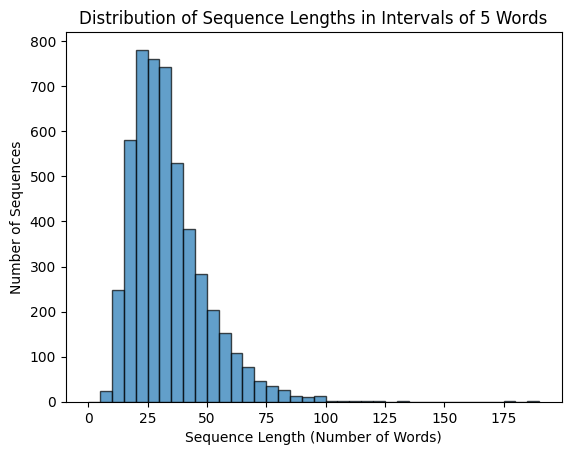

In [30]:
def plot_sequence_lengths(words, interval=5):
    # Calculate sequence lengths
    sequence_lengths = [len(seq) for seq in words]

    # Create histogram bins for intervals of specified number of words
    bins = [i * interval for i in range(max(sequence_lengths) // interval + 2)]

    # Plot histogram
    plt.hist(sequence_lengths, bins=bins, edgecolor='black', alpha=0.7)
    
    # Add labels and title
    plt.xlabel('Sequence Length (Number of Words)')
    plt.ylabel('Number of Sequences')
    plt.title(f'Distribution of Sequence Lengths in Intervals of {interval} Words')

    # Show the plot
    plt.show()

# Assuming you already loaded your data
plot_sequence_lengths(train_words, interval=5)

In [3]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_words)

# Đổi chữ thành ID
traindev_sequences = tokenizer.texts_to_sequences(traindev_words)
train_sequences = tokenizer.texts_to_sequences(train_words)
dev_sequences = tokenizer.texts_to_sequences(dev_words)
test_sequences = tokenizer.texts_to_sequences(test_words)
all_sequences = tokenizer.texts_to_sequences(all_words)


# Đổi tag thành ID
tag_to_index = {'O': 0, 'B-AGE': 1, 'B-DATE': 2, 'B-GENDER': 3, 'B-JOB': 4, 'B-LOCATION': 5, 'B-NAME': 6, 'B-ORGANIZATION': 7, 'B-PATIENT_ID': 8, 'B-SYMPTOM_AND_DISEASE': 9, 'B-TRANSPORTATION': 10, 'I-AGE': 11, 'I-DATE': 12, 'I-GENDER': 13, 'I-JOB': 14, 'I-LOCATION': 15, 'I-NAME': 16, 'I-ORGANIZATION': 17, 'I-PATIENT_ID': 18, 'I-SYMPTOM_AND_DISEASE': 19, 'I-TRANSPORTATION': 20}

traindev_tags = [[tag_to_index.get(tag) for tag in seq] for seq in traindev_tags]
train_tags = [[tag_to_index.get(tag) for tag in seq] for seq in train_tags]
dev_tags = [[tag_to_index.get(tag) for tag in seq] for seq in dev_tags]
test_tags = [[tag_to_index.get(tag) for tag in seq] for seq in test_tags]
all_tags = [[tag_to_index.get(tag) for tag in seq] for seq in all_tags]


In [15]:
# Get the word-to-index mapping
word_index = tokenizer.word_index

# Print the ID of a specific token
token_to_check = ';'
token_id = word_index.get(token_to_check)

if token_id is not None:
    print(f"The ID of '{token_to_check}' is: {token_id}")
else:
    print(f"{token_to_check} is not in the vocabulary.")
    

The ID of ';' is: 157


In [11]:
index_to_word = {index: word for word, index in word_index.items()}
word_for_id = index_to_word.get(20, "ID not found")
print(word_for_id)


)


In [13]:
def seq_id_to_word(seq):
    word = []
    for i in range(len(seq)):
        word.append(index_to_word.get(seq[i], "ID not found"))
    print(word)

seq_id_to_word([':'])

['ID not found']


In [16]:
def remove_tokens(data, tags, tokens_to_remove):
    new_data = []
    new_tags = []
    for seq, tag_seq in zip(data, tags):
        new_seq = [word for word in seq if word not in tokens_to_remove]
        new_tag_seq = [tag for word, tag in zip(seq, tag_seq) if word not in tokens_to_remove]
        new_data.append(new_seq)
        new_tags.append(new_tag_seq)
    return new_data, new_tags

tokens_to_remove = [1, 4, 9, 19, 20, 120, 157]

# Remove instances of the specified tokens
# traindev_sequences, traindev_tags = remove_tokens(traindev_sequences, traindev_tags, tokens_to_remove)
# train_sequences, train_tags = remove_tokens(train_sequences, train_tags, tokens_to_remove)
# dev_sequences, dev_tags = remove_tokens(dev_sequences, dev_tags, tokens_to_remove)
# test_sequences, test_tags = remove_tokens(test_sequences, test_tags, tokens_to_remove)


In [8]:
def entity_start_with(seq, tags, number, tagid):
    entity = []
    while number < len(tags) and (tags[number] == tagid or tags[number] == tagid + 10):
        entity.append(seq[number])
        number += 1
    return entity

def extract_entities(data, tags, tagid):
    entities = []
    entity_num = 0
    for seq in range(len(tags)):        
        for tok in range(len(tags[seq])):
            if tags[seq][tok] == tagid:
                entities.append(entity_start_with(data[seq], tags[seq], tok, tagid))
                entity_num += 1

    print(entity_num)
    return entities

# Example usage
job_list = extract_entities(traindev_sequences, traindev_tags, 4)
np.random.seed(54)
np.random.shuffle(job_list)

337


In [9]:
def remove_ett(seq, label, start, tagid):
    while label[start] == tagid or label[start] == tagid + 10:
        seq = seq[:start] + seq[start + 1:]
        label = label[:start] + label[start + 1:]   
    return seq, label
    
def make_lb(length, tagid):
    lb_array = [tagid]
    while len(lb_array) < length:
        lb_array += [tagid + 10]
    return lb_array
    
def make_seq(seq, label, start, ettlist, tagid):
    temp_data, temp_label = remove_ett(seq.copy(), label.copy(), start, tagid)
    sample_data = temp_data[:start] + ettlist[0] + temp_data[start:]
    sample_label= temp_label[:start] + make_lb(len(ettlist[0]),tagid) + temp_label[start:]
    return sample_data, sample_label

def data_aug(data, tags, ettlist, tagid):
    new_data = []
    new_label = []
    for seq in range(len(tags)):        
        for tok in range(len(tags[seq])):
            if tags[seq][tok] == tagid:
                new_data_ins, new_label_ins = make_seq(data[seq], tags[seq], tok, ettlist, tagid)
                ettlist = ettlist[1:]
                new_data.append(new_data_ins)
                new_label.append(new_label_ins)
    print(f"3 new sample: {new_data[:3]}")           
    data += new_data
    tags += new_label

In [10]:
data_aug(traindev_sequences, traindev_tags, job_list, 4)

3 new sample: [[282, 2, 3, 254, 15, 32, 107, 13, 72, 501, 18, 82, 39, 1, 150, 89, 10, 11, 105, 128, 460, 69, 329, 490, 552, 1, 137, 210, 1494, 592, 6, 238, 5, 100, 44, 119, 406, 257, 2, 47, 2, 3, 60, 807, 250, 228, 145, 243, 11, 461, 356, 268, 387, 4], [2, 3, 1795, 15, 34, 1, 237, 29, 1, 157, 102, 18, 829, 277, 1, 58, 55, 1, 15, 62, 3, 8, 72, 1, 123, 148, 49, 55, 408, 6, 237, 5, 46, 79, 104, 73, 594, 959, 4], [38, 50, 845, 1064, 685, 11, 2, 3, 1167, 2899, 5, 1157, 107, 47, 2, 7, 2, 91, 97, 26, 86, 1, 10, 2, 3, 259, 1338, 5, 13, 53, 104, 202, 73, 594, 959, 49, 106, 34, 1339, 130, 39, 5, 46, 95, 439, 80, 392, 80, 1000, 1094, 5, 151, 634, 231, 746, 716, 10, 2, 3, 172, 4]]


In [17]:
# Pad chuỗi entry theo câu
max_seq_len = max_seq_len = 200
traindev_data = pad_sequences(traindev_sequences, maxlen=max_seq_len, padding='post', truncating='post')
all_data = pad_sequences(all_sequences, maxlen=max_seq_len, padding='post', truncating='post')
train_data = pad_sequences(dev_sequences, maxlen=max_seq_len, padding='post', truncating='post')
dev_data = pad_sequences(dev_sequences, maxlen=max_seq_len, padding='post', truncating='post')
test_data = pad_sequences(test_sequences, maxlen=max_seq_len, padding='post', truncating='post')

# Pad chuỗi tag theo câu
traindev_tags = pad_sequences(traindev_tags, maxlen=max_seq_len, padding='post')
all_tags = pad_sequences(all_tags, maxlen=max_seq_len, padding='post')
train_tags = pad_sequences(train_tags, maxlen=max_seq_len, padding='post')
dev_tags = pad_sequences(dev_tags, maxlen=max_seq_len, padding='post')
test_tags = pad_sequences(test_tags, maxlen=max_seq_len, padding='post')

In [5]:
print(train_data[0])

[ 154  167  227   24  572    1  230  266   24   89  260  641    1    2
    7  174  189    1   45  113    2    3   12   67   14    2    7    6
 1117    1  340  406  641  428   30   38  107 1401 4300    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [6]:
# Module load file w2v
def load_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            word = parts[0]
            vector = list(map(float, parts[-300:])) #  dims vector embedding
            embeddings[word] = vector
    return embeddings

def create_embedding_matrix(tokenizer, embeddings, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


embedding_file_path = 'word2vec_vi_syllables_300dims.txt' # Input path file embedding (.txt)
word_embeddings = load_embeddings(embedding_file_path)
embedding_dim = 300  # dims vector embedding


# Load pre-train embedding
embeddings = load_embeddings(embedding_file_path)
# Embedding matrix
embedding_matrix = create_embedding_matrix(tokenizer, embeddings, embedding_dim)

In [7]:
print(dev_data[42])

[  99    2    3   18  121  152 1052  461   11   36   58  114   17    2
    3   92  326  197    2    3  708   20   64    1   39   28   21    1
  760   20   29    1 1124   28   21  172  632   20   29    1  359   28
   21    1  700   20   64    1  728   28    1   16 2942  177   46    2
    3   92  326   21    4    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [8]:
print(dev_tags[42])

[ 0  0  0  0  5 15 15 15  0  0  0  0  0  0  0  0  8  0  0  0  8  0  3  0
  1  0  0  0  8  0  3  0  1  0  0  0  8  0  3  0  1  0  0  0  8  0  3  0
  1  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [16]:
def prep_data_non_BIO(tags):
    tags_copy = copy.deepcopy(tags)
    
    for seq in range(tags_copy.shape[0]):
        for lb in range(tags_copy.shape[1]):
            if tags_copy[seq][lb] > 10:
                tags_copy[seq][lb] -= 10
    
    return tags_copy

traindev_tags_non_BIO = prep_data_non_BIO(traindev_tags)

In [9]:
lstm_units = 64
num_classes = 21

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True)) # trainable = False
model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True)))  # Bidirectional LSTM
model.add(Bidirectional(GRU(units=lstm_units, return_sequences=True)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          1344000   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 128)          74496     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 200, 21)           2709      
                                                                 
Total params: 1608085 (6.13 MB)
Trainable params: 1608085 (6.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
def post_processing(pred, data):
    for seq in range(pred.shape[0]):
        for label in range(pred.shape[1]):
            if label > 0 and label < 199:
                if data[seq][label] in tokens_to_remove:
                    pred[seq][label] = 0
                if pred[seq][label] == pred[seq][label+1] and pred[seq][label] < 11 and pred[seq][label] > 0:
                    pred[seq][label+1] += 10
                if pred[seq][label-1] == 0 and pred[seq][label] < 21 and pred[seq][label] > 10:
                    pred[seq][label] -= 10
                if pred[seq][label+1] == pred[seq][label] - 10 and pred[seq][label] < 21 and pred[seq][label] > 10:
                    pred[seq][label+1] = pred[seq][label]
                

In [11]:
model.fit(traindev_data, traindev_tags, epochs=10, batch_size=32)


_, accuracy = model.evaluate(test_data, test_tags)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10
251/251 [==============================] - 77s 284ms/step - loss: 0.2515 - accuracy: 0.9631
Epoch 2/10
251/251 [==============================] - 79s 316ms/step - loss: 0.0380 - accuracy: 0.9903
Epoch 3/10
251/251 [==============================] - 83s 329ms/step - loss: 0.0202 - accuracy: 0.9945
Epoch 4/10
251/251 [==============================] - 90s 357ms/step - loss: 0.0143 - accuracy: 0.9960
Epoch 5/10
251/251 [==============================] - 87s 345ms/step - loss: 0.0109 - accuracy: 0.9969
Epoch 6/10
251/251 [==============================] - 83s 330ms/step - loss: 0.0091 - accuracy: 0.9974
Epoch 7/10
251/251 [==============================] - 84s 336ms/step - loss: 0.0075 - accuracy: 0.9979
Epoch 8/10
251/251 [==============================] - 85s 337ms/step - loss: 0.0062 - accuracy: 0.9982
Epoch 9/10
251/251 [==============================] - 86s 342ms/step - loss: 0.0055 - accuracy: 0.9984
Epoch 10/10
94/94 [==============================] - 13s 123ms/step - los

In [15]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)
# trainable true

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 16s 160ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    569419
                B-AGE       0.71      0.66      0.68       582
               B-DATE       0.88      0.87      0.88      1654
             B-GENDER       0.75      0.70      0.72       462
                B-JOB       0.70      0.47      0.56       173
           B-LOCATION       0.76      0.74      0.75      4441
               B-NAME       0.83      0.55      0.66       318
       B-ORGANIZATION       0.81      0.81      0.81       771
         B-PATIENT_ID       0.88      0.80      0.84      2005
B-SYMPTOM_AND_DISEASE       0.83      0.77      0.80      1136
     B-TRANSPORTATION       0.80      0.54      0.65       193
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.91      0.93      0.92      1752
             I-GENDER       0.00      0.00      0.00         1
                I-JOB       0.64      0.38      0.48  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)
# trainable true with data aug fixed

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 14s 136ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    569419
                B-AGE       0.67      0.70      0.68       582
               B-DATE       0.88      0.88      0.88      1654
             B-GENDER       0.73      0.70      0.72       462
                B-JOB       0.61      0.50      0.55       173
           B-LOCATION       0.77      0.74      0.75      4441
               B-NAME       0.80      0.53      0.63       318
       B-ORGANIZATION       0.85      0.78      0.81       771
         B-PATIENT_ID       0.89      0.80      0.84      2005
B-SYMPTOM_AND_DISEASE       0.84      0.77      0.81      1136
     B-TRANSPORTATION       0.77      0.52      0.62       193
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.91      0.92      0.92      1752
             I-GENDER       0.00      0.00      0.00         1
                I-JOB       0.60      0.49      0.54  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)
# trainable true with data aug

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 14s 136ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    569419
                B-AGE       0.69      0.70      0.69       582
               B-DATE       0.89      0.87      0.88      1654
             B-GENDER       0.72      0.73      0.72       462
                B-JOB       0.59      0.60      0.59       173
           B-LOCATION       0.75      0.75      0.75      4441
               B-NAME       0.80      0.54      0.65       318
       B-ORGANIZATION       0.87      0.75      0.81       771
         B-PATIENT_ID       0.89      0.80      0.84      2005
B-SYMPTOM_AND_DISEASE       0.84      0.76      0.80      1136
     B-TRANSPORTATION       0.80      0.53      0.64       193
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.91      0.92      0.92      1752
             I-GENDER       0.00      0.00      0.00         1
                I-JOB       0.58      0.50      0.54  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)
# trainable false

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 9s 95ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    569419
                B-AGE       0.68      0.70      0.69       582
               B-DATE       0.89      0.87      0.88      1654
             B-GENDER       0.70      0.73      0.72       462
                B-JOB       0.61      0.49      0.54       173
           B-LOCATION       0.76      0.71      0.73      4441
               B-NAME       0.75      0.40      0.52       318
       B-ORGANIZATION       0.84      0.77      0.80       771
         B-PATIENT_ID       0.89      0.80      0.84      2005
B-SYMPTOM_AND_DISEASE       0.87      0.68      0.77      1136
     B-TRANSPORTATION       0.75      0.48      0.59       193
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.92      0.92      0.92      1752
             I-GENDER       0.00      0.00      0.00         1
                I-JOB       0.69      0.46      0.55  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
predictions = model.predict(traindev_data)
pred_tags = np.argmax(predictions, axis=-1)
# trainable true

print(classification_report(traindev_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

231/231 [==============================] - 29s 126ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       1.00      1.00      1.00   1410200
                B-AGE       0.97      0.99      0.98      1229
               B-DATE       0.99      1.00      0.99      3788
             B-GENDER       0.97      0.97      0.97       977
                B-JOB       0.98      0.96      0.97       716
           B-LOCATION       0.99      0.98      0.99      8795
               B-NAME       0.99      0.98      0.99       620
       B-ORGANIZATION       0.98      0.97      0.97      1795
         B-PATIENT_ID       1.00      1.00      1.00      5058
B-SYMPTOM_AND_DISEASE       0.98      0.98      0.98      2225
     B-TRANSPORTATION       1.00      0.99      0.99       339
                I-AGE       0.00      0.00      0.00         2
               I-DATE       0.99      1.00      1.00      3763
             I-GENDER       0.00      0.00      0.00        18
                I-JOB       0.97      0.98      0.97  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
predictions = model.predict(traindev_data)
pred_tags = np.argmax(predictions, axis=-1)
# trainable false

print(classification_report(traindev_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

220/220 [==============================] - 21s 97ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       1.00      1.00      1.00   1347627
                B-AGE       0.92      0.97      0.95      1043
               B-DATE       0.99      0.99      0.99      3652
             B-GENDER       0.89      0.95      0.92       819
                B-JOB       0.86      0.82      0.84       337
           B-LOCATION       0.97      0.93      0.95      8135
               B-NAME       0.86      0.73      0.79       537
       B-ORGANIZATION       0.94      0.92      0.93      1688
         B-PATIENT_ID       0.98      0.99      0.99      4516
B-SYMPTOM_AND_DISEASE       0.95      0.86      0.90      2205
     B-TRANSPORTATION       0.95      0.89      0.92       313
                I-AGE       0.00      0.00      0.00         2
               I-DATE       0.99      0.99      0.99      3618
             I-GENDER       1.00      0.19      0.32        16
                I-JOB       0.85      0.79      0.82  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)
post_processing(pred_tags, test_data)
# trainable true

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 14s 151ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    569419
                B-AGE       0.71      0.66      0.68       582
               B-DATE       0.88      0.87      0.88      1654
             B-GENDER       0.75      0.70      0.72       462
                B-JOB       0.57      0.45      0.50       173
           B-LOCATION       0.74      0.74      0.74      4441
               B-NAME       0.83      0.55      0.66       318
       B-ORGANIZATION       0.72      0.81      0.77       771
         B-PATIENT_ID       0.88      0.80      0.84      2005
B-SYMPTOM_AND_DISEASE       0.78      0.78      0.78      1136
     B-TRANSPORTATION       0.81      0.54      0.65       193
                I-AGE       1.00      0.17      0.29         6
               I-DATE       0.91      0.93      0.92      1752
             I-GENDER       0.00      0.00      0.00         1
                I-JOB       0.67      0.35      0.46  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)
post_processing(pred_tags, test_data)
# trainable true with data aug 

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 14s 145ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    569419
                B-AGE       0.69      0.70      0.69       582
               B-DATE       0.88      0.87      0.88      1654
             B-GENDER       0.72      0.73      0.72       462
                B-JOB       0.52      0.58      0.55       173
           B-LOCATION       0.73      0.75      0.74      4441
               B-NAME       0.79      0.54      0.64       318
       B-ORGANIZATION       0.79      0.75      0.77       771
         B-PATIENT_ID       0.89      0.80      0.84      2005
B-SYMPTOM_AND_DISEASE       0.80      0.76      0.78      1136
     B-TRANSPORTATION       0.80      0.53      0.64       193
                I-AGE       0.50      0.17      0.25         6
               I-DATE       0.91      0.92      0.92      1752
             I-GENDER       0.00      0.00      0.00         1
                I-JOB       0.63      0.50      0.55  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)
post_processing(pred_tags, test_data)
# trainable true with data aug fixed

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 12s 131ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    569419
                B-AGE       0.67      0.70      0.68       582
               B-DATE       0.88      0.87      0.88      1654
             B-GENDER       0.73      0.70      0.72       462
                B-JOB       0.48      0.50      0.49       173
           B-LOCATION       0.74      0.74      0.74      4441
               B-NAME       0.80      0.53      0.63       318
       B-ORGANIZATION       0.74      0.78      0.76       771
         B-PATIENT_ID       0.89      0.80      0.84      2005
B-SYMPTOM_AND_DISEASE       0.80      0.78      0.79      1136
     B-TRANSPORTATION       0.78      0.52      0.62       193
                I-AGE       1.00      0.17      0.29         6
               I-DATE       0.91      0.92      0.92      1752
             I-GENDER       0.00      0.00      0.00         1
                I-JOB       0.64      0.45      0.53  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)
post_processing(pred_tags, test_data)
# trainable true non BIO

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 15s 147ms/step
                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    569419
                B-AGE       0.69      0.69      0.69       582
               B-DATE       0.88      0.87      0.88      1654
             B-GENDER       0.72      0.71      0.71       462
                B-JOB       0.44      0.42      0.43       173
           B-LOCATION       0.72      0.74      0.73      4441
               B-NAME       0.80      0.52      0.63       318
       B-ORGANIZATION       0.65      0.79      0.71       771
         B-PATIENT_ID       0.89      0.80      0.84      2005
B-SYMPTOM_AND_DISEASE       0.77      0.78      0.77      1136
     B-TRANSPORTATION       0.80      0.54      0.65       193
                I-AGE       0.67      0.33      0.44         6
               I-DATE       0.91      0.93      0.92      1752
             I-GENDER       0.00      0.00      0.00         

In [18]:
predictions = model.predict(dev_data)
pred_tags = np.argmax(predictions, axis=-1)
post_processing(pred_tags, dev_data)
pred_tags[0][199]=11
print(classification_report(dev_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

63/63 [==============================] - 5s 81ms/step
                       precision    recall  f1-score   support

                    O       0.99      1.00      0.99    380389
                B-AGE       0.82      0.68      0.74       361
               B-DATE       0.93      0.92      0.92      1103
             B-GENDER       0.83      0.75      0.79       277
                B-JOB       0.73      0.43      0.54       132
           B-LOCATION       0.79      0.75      0.77      2737
               B-NAME       0.90      0.60      0.72       188
       B-ORGANIZATION       0.70      0.78      0.74       551
         B-PATIENT_ID       0.89      0.81      0.85      1276
B-SYMPTOM_AND_DISEASE       0.79      0.83      0.81       766
     B-TRANSPORTATION       0.86      0.72      0.79        87
                I-AGE       0.00      0.00      0.00         0
               I-DATE       0.94      0.96      0.95      1118
             I-GENDER       0.00      0.00      0.00         2


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Rec

In [15]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 4s 38ms/step
                       precision    recall  f1-score   support

                    O       0.98      0.99      0.99    271361
                B-AGE       0.62      0.66      0.64       516
               B-DATE       0.87      0.88      0.87      1593
             B-GENDER       0.67      0.72      0.69       392
                B-JOB       0.58      0.45      0.50       170
           B-LOCATION       0.73      0.66      0.69      4293
               B-NAME       0.84      0.64      0.73       252
       B-ORGANIZATION       0.83      0.74      0.78       768
         B-PATIENT_ID       0.86      0.86      0.86      1676
B-SYMPTOM_AND_DISEASE       0.81      0.72      0.76      1112
     B-TRANSPORTATION       0.79      0.59      0.67       158
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.90      0.92      0.91      1685
             I-GENDER       0.00      0.00      0.00         1


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
predictions = model.predict(test_data)
pred_tags = np.argmax(predictions, axis=-1)

print(classification_report(test_tags.flatten(), pred_tags.flatten(), target_names=list(tag_to_index.keys())))

94/94 [==============================] - 3s 21ms/step


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                    O       0.99      0.99      0.99    421675
                B-AGE       0.73      0.67      0.70       517
               B-DATE       0.87      0.89      0.88      1577
             B-GENDER       0.79      0.70      0.75       396
                B-JOB       0.71      0.37      0.49       171
           B-LOCATION       0.71      0.71      0.71      4260
               B-NAME       0.79      0.62      0.69       252
       B-ORGANIZATION       0.85      0.74      0.79       768
         B-PATIENT_ID       0.88      0.88      0.88      1657
B-SYMPTOM_AND_DISEASE       0.80      0.77      0.78      1109
     B-TRANSPORTATION       0.75      0.60      0.67       157
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.90      0.95      0.92      1665
             I-GENDER       0.00      0.00      0.00         1
                I-JOB       0.68      0.37      0.47  

C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# JOB luôn là tag perform tệ nhất ở các lần thử, các model khác nhau, do ít dữ liệu train?

In [18]:
def find_dist(label):
    label_counts = {}
    
    for seq in range(label.shape[0]):
        for tag in range(label.shape[1]):
            current_label = label[seq][tag]
            
            if current_label not in label_counts:
                label_counts[current_label] = 1
            else:
                label_counts[current_label] += 1
    sorted_label_counts = sorted(label_counts.items(), key=lambda x: x[0])
    for label_type, count in sorted_label_counts:
        print(f"Label {label_type}: {count}")


find_dist(all_tags)


Label 0: 2106076
Label 1: 1846
Label 2: 5857
Label 3: 1466
Label 4: 551
Label 5: 14280
Label 6: 985
Label 7: 2679
Label 8: 7250
Label 9: 3711
Label 10: 612
Label 11: 14
Label 12: 6004
Label 13: 16
Label 14: 1012
Label 15: 33767
Label 16: 248
Label 17: 12162
Label 18: 69
Label 19: 6582
Label 20: 213


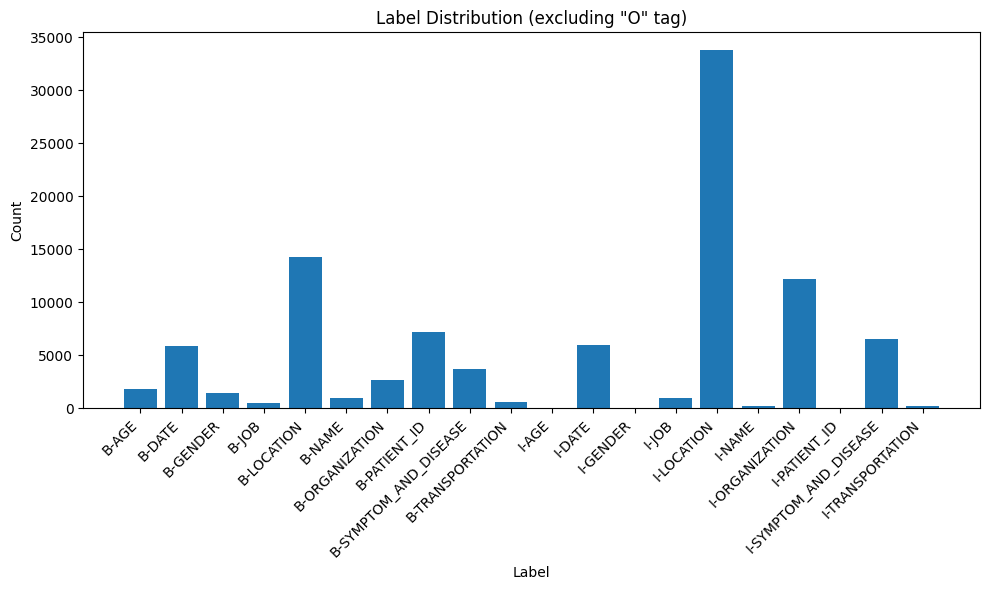

In [28]:
def find_dist(label):
    label_counts = {}

    for seq in range(label.shape[0]):
        for tag in range(label.shape[1]):
            current_label = label[seq][tag]

            # Check if the label is not equal to 0
            if current_label != 0:
                if current_label not in label_counts:
                    label_counts[current_label] = 1
                else:
                    label_counts[current_label] += 1

    sorted_label_counts = sorted(label_counts.items(), key=lambda x: x[0])

    # Create a list of labels in the correct order
    label_order = [key for key in sorted(tag_to_index.keys(), key=lambda x: tag_to_index[x])]

    # Create lists to store label names and corresponding counts
    labels = [label_order[label_type] for label_type, _ in sorted_label_counts]
    counts = [count for _, count in sorted_label_counts]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, tick_label=labels)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Label Distribution (excluding "O" tag)')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()  # Ensure labels do not overlap
    plt.show()
# Assuming `all_tags` is a NumPy array
find_dist(all_tags)